# Getting Data

*author: Joseph Montoya*

This notebook demonstrates a few basic examples from matminer's data retrieval features.  Matminer supports data retrieval from the following sources.

* [Materials Project](https://materialsproject.org)
* [Citrine Informatics](https://citrination.com)
* [The Materials Platform for Data Science (MPDS)](https://mpds.io) 
* [The Materials Data Facility](https://materialsdatafacility.org/)

This notebook was last updated 11/15/18 for version 0.4.5 of matminer.

Each resource has a corresponding object in matminer designed for retrieving data and preprocessing it into a pandas dataframe.  In addition, matminer can also access and aggregate data from your own [mongo database](https://www.mongodb.com/), if you have one.

![data retrieval](data_retrieval.png)

## Materials Project

The materials project data retrieval tool, `matminer.data_retrieval.retrieve_MP.MPDataRetrieval` is initialized using an api_key that can be found on your personal dashboard page on [materialsproject.org](materialsproject.org) if you've created an account.  If you've set your api key via pymatgen (e.g. `pmg config --add PMG_MAPI_KEY YOUR_API_KEY_HERE`), the data retrieval tool may be initialized without an input argument.

In [1]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval

In [2]:
mpdr = MPDataRetrieval() # or MPDataRetrieval(api_key=YOUR_API_KEY here)

Getting a dataframe corresponding to the materials project is essentially equivalent to using the MPRester's query method.(see [`pymatgen.ext.matproj.MPRester`](http://pymatgen.org/_modules/pymatgen/ext/matproj.html))  The inputs are  `criteria`, a mongo-style dictionary with which to filter the data, and `properties`, a list of supported properties which to return.  See the [MAPI documentation](https://github.com/materialsproject/mapidoc/tree/master/materials) for a list of and information about supported properties.

#### Example 1: Get densities of all elemental materials, i. e. those that contain one element

In [3]:
df = mpdr.get_dataframe(criteria={"nelements": 1}, properties=['density', 'pretty_formula'])
print("There are {} entries on MP with 1 element".format(df['density'].count()))

There are 565 entries on MP with 1 element


In [4]:
df.head()

,density,pretty_formula
material_id,,
mp-862690,8.281682,Ac
mp-10018,8.305509,Ac
mp-124,9.948341,Ag
mp-989737,9.922633,Ag
mp-8566,9.909385,Ag


#### Example 2: Get all bandgaps larger than 4.0 eV

In [5]:
df = mpdr.get_dataframe({"band_gap": {"$gt": 4.0}}, ['pretty_formula', 'band_gap'])

In [6]:
print("There are {} entries on MP with a band gap larger than 4.0".format(df['band_gap'].count()))

There are 6232 entries on MP with a band gap larger than 4.0


In [7]:
df.to_csv('ss.csv')

#### Example 3: Get all VRH shear and bulk moduli from the "elasticity" sub-document for which no warnings are found

In [8]:
df = mpdr.get_dataframe({"elasticity": {"$exists": True}, "elasticity.warnings": []},
                        ['pretty_formula', 'elasticity.K_VRH', 'elasticity.G_VRH'])

In [9]:
print("There are {} elastic entries on MP with no warnings".format(df['elasticity.K_VRH'].count()))

There are 13934 elastic entries on MP with no warnings


In [10]:
df.describe()

,elasticity.K_VRH,elasticity.G_VRH
count,13934.00000,13934.000000
mean,100.56294,41.112315
std,71.93579,122.037330
min,-0.00000,-8480.000000
25%,44.00000,16.000000
50%,84.00000,33.000000
75%,144.00000,63.000000
max,591.00000,5303.000000


Now let us do a more sophisticated query and ask for more properties such as "bandstructure" and "dos" (density of states) that are stored as pymatgen objects. The query commands under criteria are common MongoDB syntax.

In [11]:
df = mpdr.get_dataframe(criteria={"elasticity": {"$exists": True}, 
                         "elasticity.warnings": [],
                         "elements": {"$all": ["Pb", "Te"]},
                         "e_above_hull": {"$lt": 1e-6}}, # to limit the number of hits for the sake of time
                        properties = ["elasticity.K_VRH", "elasticity.G_VRH", "pretty_formula", 
                                      "e_above_hull", "bandstructure", "dos"])

In [12]:
print("There are {} elastic entries on MP with no warnings that contain "
      "Pb and Te with energy above hull ~ 0.0 eV".format(df['elasticity.K_VRH'].count()))

There are 3 elastic entries on MP with no warnings that contain Pb and Te with energy above hull ~ 0.0 eV


In [13]:
df.head()

,elasticity.K_VRH,elasticity.G_VRH,pretty_formula,e_above_hull,bandstructure,dos
material_id,,,,,,
mp-19717,40.0,24.0,TePb,0,<pymatgen.electronic_structure.bandstructure.B...,Complete DOS for Full Formula (Te1 Pb1)\nReduc...
mp-20740,25.0,13.0,Tl4Te3Pb,0,<pymatgen.electronic_structure.bandstructure.B...,Complete DOS for Full Formula (Tl8 Te6 Pb2)\nR...
mp-605028,34.0,16.0,Te2Pd3Pb2,0,<pymatgen.electronic_structure.bandstructure.B...,Complete DOS for Full Formula (Te4 Pd6 Pb4)\nR...


Let's look at the band structure and density of states of some of these stable compounds that contain Pb and Te which are interesting for thermoelectrics applications:

/Users/daniel/.conda/envs/matminer/lib/python3.6/site-packages/pymatgen/electronic_structure/plotter.py:2179: UserWarning:

Cannot get element projected data; either the projection data doesn't exist, or you don't have a compound with exactly 2 or 3 unique elements.



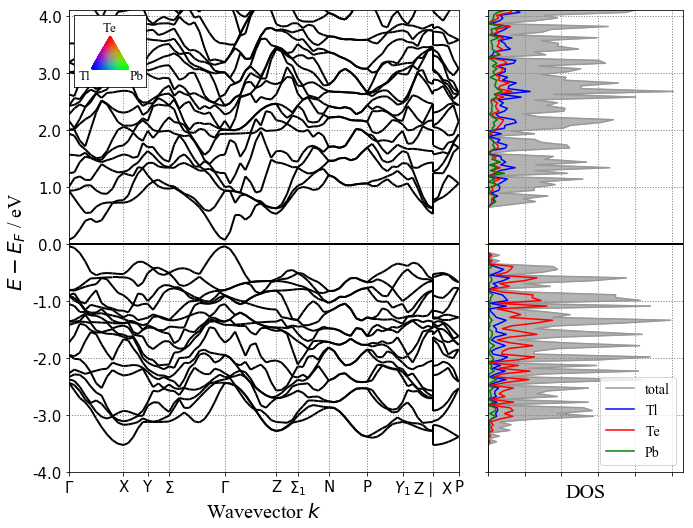

In [14]:
%matplotlib inline
from pymatgen.electronic_structure.plotter import BSDOSPlotter

mpid = 'mp-20740'
idx = df.index[df.index==mpid][0]
plt = BSDOSPlotter().get_plot(bs=df.loc[idx, 'bandstructure'], dos=df.loc[idx, 'dos']);
plt.show()

## Citrine informatics

The Citrination data retrieval tool, `matminer.data_retrieval.retrieve_Citrine.CitrineDataRetrieval` is initialized using an api_key that can be found on your "Account Settings" tab under your username in the upper right hand corner of the user interface at [citrination.com](citrination.com).  You can also set an environment variable, `CITRINE_KEY` to have your API key read automatically by the citrine informatics python API, (e. g. put `export CITRINE_KEY=YOUR_API_KEY_HERE` into your .bashrc).

In [15]:
from matminer.data_retrieval.retrieve_Citrine import CitrineDataRetrieval

#### Example 1: Get band gaps of various entries with formula PbTe

In [16]:
cdr = CitrineDataRetrieval() # or CitrineDataRetrieval(api_key=YOUR_API_KEY) if $CITRINE_KEY is not set

In [17]:
df = cdr.get_dataframe(criteria={'formula':'Si', 'data_type': 'EXPERIMENTAL'}, 
                       properties=['Band gap'],
                       secondary_fields=True)

100%|██████████| 7/7 [00:00<00:00, 73.09it/s]

all available fields:
['chemicalFormula', 'Band gap-dataType', 'references', 'Band gap', 'Band gap-conditions', 'category', 'uid', 'Crystallinity', 'Band gap-units', 'Band gap-methods']

suggested common fields:
['chemicalFormula', 'references', 'Band gap', 'Band gap-conditions', 'Band gap-dataType', 'Band gap-methods', 'Band gap-units', 'Crystallinity']


In [18]:
cdr.get_dataframe?

#### Example 2: Get adsorption energies of O\* and OH\*

In [19]:
df_OH = cdr.get_dataframe(criteria={}, properties=['adsorption energy of OH'], secondary_fields=True)
df_O = cdr.get_dataframe(criteria={}, properties=['adsorption energy of O'], secondary_fields=True)

100%|██████████| 9/9 [00:00<00:00, 15.47it/s]


all available fields:
['chemicalFormula', 'Surface facet', 'Adsorption energy of OH-conditions', 'references', 'Morphology', 'category', 'uid', 'Adsorption energy of OH-units', 'Adsorption energy of OH', 'Adsorption energy of OH-dataType']

suggested common fields:
['chemicalFormula', 'references', 'Adsorption energy of OH', 'Adsorption energy of OH-conditions', 'Adsorption energy of OH-dataType', 'Adsorption energy of OH-units', 'Morphology', 'Surface facet']


100%|██████████| 21/21 [00:00<00:00, 35.11it/s]

all available fields:
['Reconstruction', 'chemicalFormula', 'Surface facet', 'references', 'Adsorption energy of O-units', 'category', 'uid', 'Adsorption energy of O-conditions', 'Adsorption energy of O']

suggested common fields:
['chemicalFormula', 'references', 'Adsorption energy of O', 'Adsorption energy of O-conditions', 'Adsorption energy of O-units', 'Reconstruction', 'Surface facet']


In [20]:
df_OH.head()

,chemicalFormula,references,Adsorption energy of OH,Adsorption energy of OH-conditions,Adsorption energy of OH-dataType,Adsorption energy of OH-units,Morphology,Surface facet
1,Pt,"[{'citation': '10.1039/c2cc30281k', 'doi': '10...",2.44,NaN,NaN,eV,NaN,(111)
2,Cu,"[{'citation': '10.1016/s1872-2067(12)60642-1',...",-3.55,NaN,COMPUTATIONAL,eV,NaN,(211)
3,ZnO,"[{'citation': '10.1016/s1872-2067(12)60642-1',...",-3.03,NaN,COMPUTATIONAL,eV,Thin film,NaN
4,Fe,"[{'citation': '10.1016/j.corsci.2012.11.011', ...",-3.95,NaN,NaN,eV,NaN,(100)
5,Pt,"[{'citation': '10.1021/jp807094m', 'doi': '10....",2.71,"[{'name': 'Site', 'scalars': [{'value': 'Top s...",NaN,eV,NaN,(111)


In [21]:
df_O.head()

,chemicalFormula,references,Adsorption energy of O,Adsorption energy of O-conditions,Adsorption energy of O-units,Reconstruction,Surface facet
1,Fe,"[{'citation': '10.1016/j.jcat.2007.04.018', 'd...",-5.42,NaN,eV,NaN,(111)
2,Pt,"[{'citation': '10.1002/cctc.201100308', 'doi':...",1.53,NaN,eV,NaN,(111)
3,Pt,"[{'citation': '10.1021/jp307055j', 'doi': '10....",-4.54,NaN,eV,NaN,(111)
4,Co,"[{'citation': '10.1021/jp710674q', 'doi': '10....",2.37,"[{'name': 'Site', 'scalars': [{'value': 'FCC s...",eV,NaN,(0001)
5,Rh,"[{'citation': '10.1007/bf00806980', 'doi': '10...",-300,NaN,kJ/mol,NaN,(110)


## MPDS - The Materials Platform for Data Science

The [Materials Platform for Data Science](https://mpds.io/) interface is contained in `matminer.data_retrieval.retrieve_MPDS.MPDSDataRetrieval`, and is invoked using an API key and an optional endpoint.  Similarly to the Citrine and MP interfaces, MPDS can be invoked without specifying your API key if MPDS_KEY is set as an environment variable (e. g. put `export MPDS_KEY=YOUR_MPDS_KEY` into your .bashrc or .bash_profile).

In [22]:
from matminer.data_retrieval.retrieve_MPDS import MPDSDataRetrieval

In [23]:
mpdsdr = MPDSDataRetrieval() # or MPDSDataRetrieval(api_key=YOUR_API_KEY)

The `get_dataframe` method of the MPDSDataRetrieval class uses a search functionality documented on the [MPDS website](http://developer.mpds.io/#Categories).  Basically, the `search` keyword argument should take a dictionary with keys and values corresponding to search categories and values.  Note that the search functionality of the MPDS interface may be severely limited without full (i.e. paid subscription) access to the database.

In [24]:
df = mpdsdr.get_dataframe(criteria={"elements": "K-Ag", "props": "heat capacity"})


Got 5 hits


In [25]:
df.head()

,Phase,Formula,SG,Entry,Property,Units,Value
0,30000,KAg4I5 rt,213,P1201629-3,heat capacity at constant pressure,J K-1 g-at.-1,30.5
1,79286,K2NaAg3[CN]6 lt,12,P1307433-3,heat capacity at constant pressure,J K-1 g-at.-1,83.0
2,79286,K2NaAg3[CN]6 lt,12,P1307433-4,heat capacity at constant pressure,J K-1 g-at.-1,112.0
3,79286,K2NaAg3[CN]6 lt,12,P1307434-3,heat capacity at constant pressure,J K-1 g-at.-1,78.0
4,79286,K2NaAg3[CN]6 lt,12,P1307434-4,heat capacity at constant pressure,J K-1 g-at.-1,11.0


## MDF - The Materials Data Facility


The MDF data retrieval tool, `matminer.data_retrieval.retrieve_MDF.MDFDataRetrieval` is initialized using a Globus initialization key.  Upon the first invocation of a MDFDataRetrieval object, you should be prompted with a string of numbers and letters you can enter on the MDF Globus authentication web site.  One advantage of this system is that it doesn't actually require authentication at all.  You can use `anonymous=True` and several of the MDF datasets will be available.  However, a number of them will not, and you will have to authenticate using the web to access the entirety of MDF.

In [26]:
from matminer.data_retrieval.retrieve_MDF import MDFDataRetrieval

In [27]:
mdf_dr = MDFDataRetrieval(anonymous=True) # Or anonymous=False if you have a Globus login

In [28]:
df = mdf_dr.get_dataframe(criteria={'elements': ['Ag', 'Be'], 'sources': ["oqmd"]})

In [29]:
df.head()

,crystal_structure.cross_reference.icsd,crystal_structure.number_of_atoms,crystal_structure.space_group_number,crystal_structure.volume,dft.converged,dft.cutoff_energy,dft.exchange_correlation_functional,files.0.data_type,files.0.filename,files.0.globus,...,oqmd.delta_e.units,oqmd.delta_e.value,oqmd.magnetic_moment.units,oqmd.magnetic_moment.value,oqmd.stability.units,oqmd.stability.value,oqmd.total_energy.units,oqmd.total_energy.value,oqmd.volume_pa.units,oqmd.volume_pa.value
0,NaN,2,221,24.0794,True,520.0,PBE,"ASCII text, with very long lines, with no line...",86132.json,globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/...,...,NaN,NaN,bohr/atom,NaN,NaN,NaN,eV/atom,-3.105143,angstrom^3/atom,12.0397
1,NaN,4,225,40.8748,True,249.8,PBE,"ASCII text, with very long lines, with no line...",113626.json,globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/...,...,NaN,NaN,bohr/atom,NaN,NaN,NaN,eV/atom,-3.272963,angstrom^3/atom,10.2187
2,NaN,2,221,25.2675,True,249.8,PBE,"ASCII text, with very long lines, with no line...",537497.json,globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/...,...,NaN,NaN,bohr/atom,NaN,NaN,NaN,eV/atom,-3.125454,angstrom^3/atom,12.6338
3,NaN,4,139,40.6980,True,520.0,PBE,"ASCII text, with very long lines, with no line...",71045.json,globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/...,...,eV/atom,0.201601,bohr/atom,NaN,eV/atom,0.201601,eV/atom,-3.320249,angstrom^3/atom,10.1745
4,NaN,4,225,40.8748,True,520.0,PBE,"ASCII text, with very long lines, with no line...",113627.json,globus://e38ee745-6d04-11e5-ba46-22000b92c6ec/...,...,eV/atom,0.222443,bohr/atom,NaN,eV/atom,0.222443,eV/atom,-3.299407,angstrom^3/atom,10.2187


In [30]:
print("There are {} entries in the Ag-Be chemical system".format(len(df)))

There are 421 entries in the Ag-Be chemical system
